# PROYECTO SUSTITUTO

## Descargar la información de Kaggle

- Crea un archivo `kaggle.json` con tu token de autenticación (en Kaggle $\to$ haz clic en el icono de usuario en la parte superior derecha $\to$ configuración $\to$ API crear nuevo token).

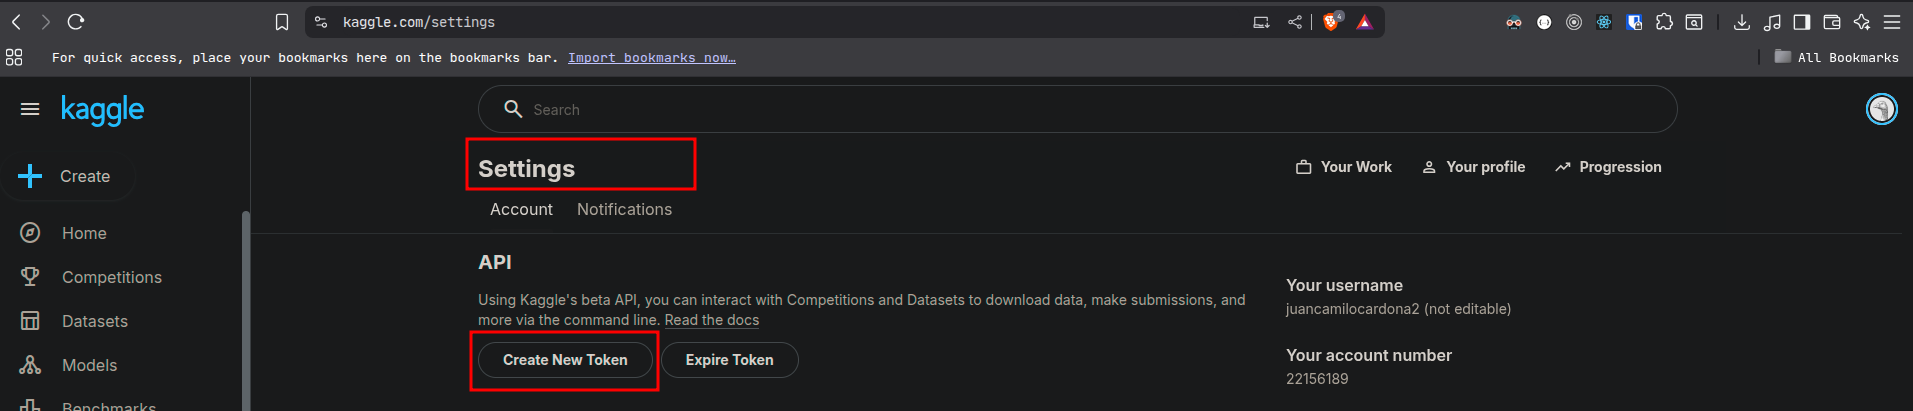

- Subir el archivo en el pánel de archivos la izquierda del notebook

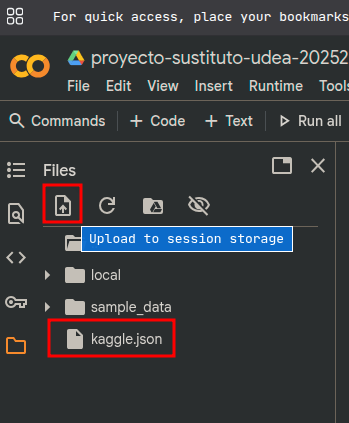

In [15]:
!pip install kaggle rlxutils -q

  Preparing metadata (setup.py) ... done


- Luego ejecutar la siguiente celda

In [16]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai4eng-20242

udea-ai4eng-20242.zip: Skipping, found more recently modified local copy (use --force to force download)


- Descomprimir y visualizar data

In [17]:
!unzip udea*.zip > /dev/null

replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [18]:
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  50135751 test.csv
   692501  10666231 118025055 train.csv
  1286075  15528571 172877479 total


- Cargar el archivo `train.csv` con pandas



In [19]:
import pandas as pd
import numpy as np

z = pd.read_csv("train.csv")
print ("shape of loaded dataframe", z.shape)


shape of loaded dataframe (692500, 12)


In [20]:
z.head()

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Postgrado,No,medio-alto
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Técnica o tecnológica incompleta,No,bajo
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No,bajo
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Secundaria (Bachillerato) completa,No,alto
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Primaria completa,No,medio-bajo


## Se usaran solo dos columnas para configurar el modelo:

- Debemos predecir la columna `RENDIMIENTO_GLOBAL`

- Se usará las columnas:
  - `ESTU_PRGM_DEPARTAMENTO` la cual se tendrá que convertir usando una codificación one-hot **onehot encoding**
  - `FAMI_ESTRATOVIVIENDA` la cual se tendrá que convertir usando una codificación one-hot **onehot encoding**

In [21]:
z = z[['ESTU_PRGM_DEPARTAMENTO',	'FAMI_ESTRATOVIVIENDA', 'RENDIMIENTO_GLOBAL']]
z.head()

,ESTU_PRGM_DEPARTAMENTO,FAMI_ESTRATOVIVIENDA,RENDIMIENTO_GLOBAL
0,BOGOTÁ,Estrato 3,medio-alto
1,ATLANTICO,Estrato 3,bajo
2,BOGOTÁ,Estrato 3,bajo
3,SANTANDER,Estrato 4,alto
4,ANTIOQUIA,Estrato 3,medio-bajo


In [22]:
print(f"ESTU_PRGM_DEPARTAMENTO: {z.ESTU_PRGM_DEPARTAMENTO.value_counts()}")
print()
print(f"FAMI_ESTRATOVIVIENDA: {z.FAMI_ESTRATOVIVIENDA.value_counts()}")

ESTU_PRGM_DEPARTAMENTO: ESTU_PRGM_DEPARTAMENTO
BOGOTÁ             282159
ANTIOQUIA           83607
VALLE               44588
ATLANTICO           41020
SANTANDER           28828
NORTE SANTANDER     22588
BOLIVAR             20629
BOYACA              14048
CUNDINAMARCA        14018
NARIÑO              13454
RISARALDA           12679
CORDOBA             12188
TOLIMA              11921
CALDAS              11640
CAUCA               11471
HUILA                9995
MAGDALENA            9512
SUCRE                8674
CESAR                8279
QUINDIO              8229
META                 7910
LA GUAJIRA           4778
CHOCO                4289
CAQUETA              2659
CASANARE             1852
PUTUMAYO              795
ARAUCA                589
AMAZONAS               40
GUAVIARE               37
VAUPES                 14
SAN ANDRES             10
Name: count, dtype: int64

FAMI_ESTRATOVIVIENDA: FAMI_ESTRATOVIVIENDA
Estrato 2      232671
Estrato 3      210685
Estrato 1      111991
Estrato 4  

<Axes: xlabel='ESTU_PRGM_DEPARTAMENTO'>

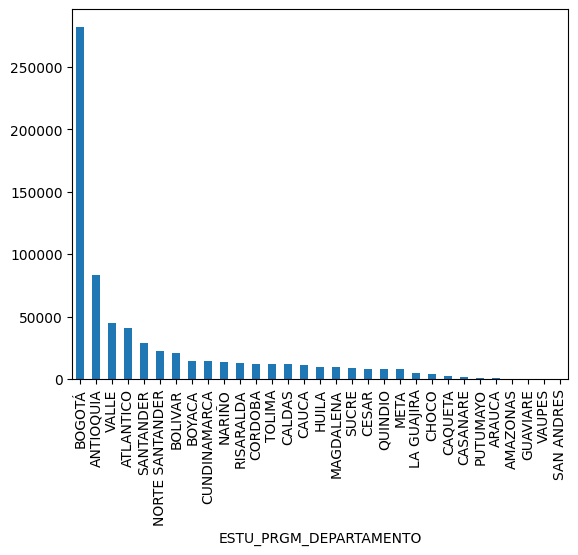

In [23]:
z.ESTU_PRGM_DEPARTAMENTO.value_counts().plot(kind='bar')

<Axes: xlabel='FAMI_ESTRATOVIVIENDA'>

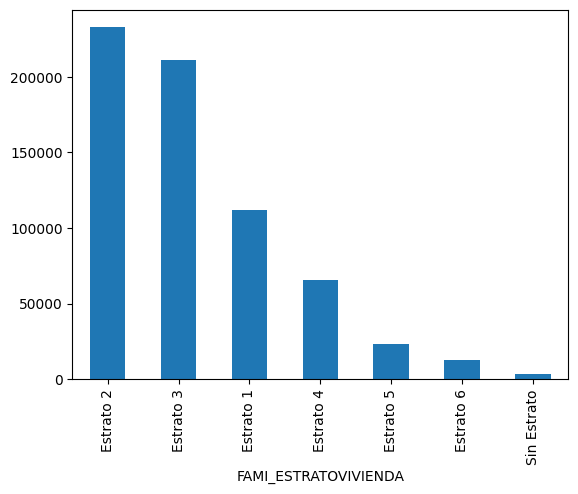

In [24]:
z.FAMI_ESTRATOVIVIENDA.value_counts().plot(kind='bar')

- Inspeccionar visualmente si estas dos columnas tienen un comportamiento distintivo con respecto a lo que queremos predecir.

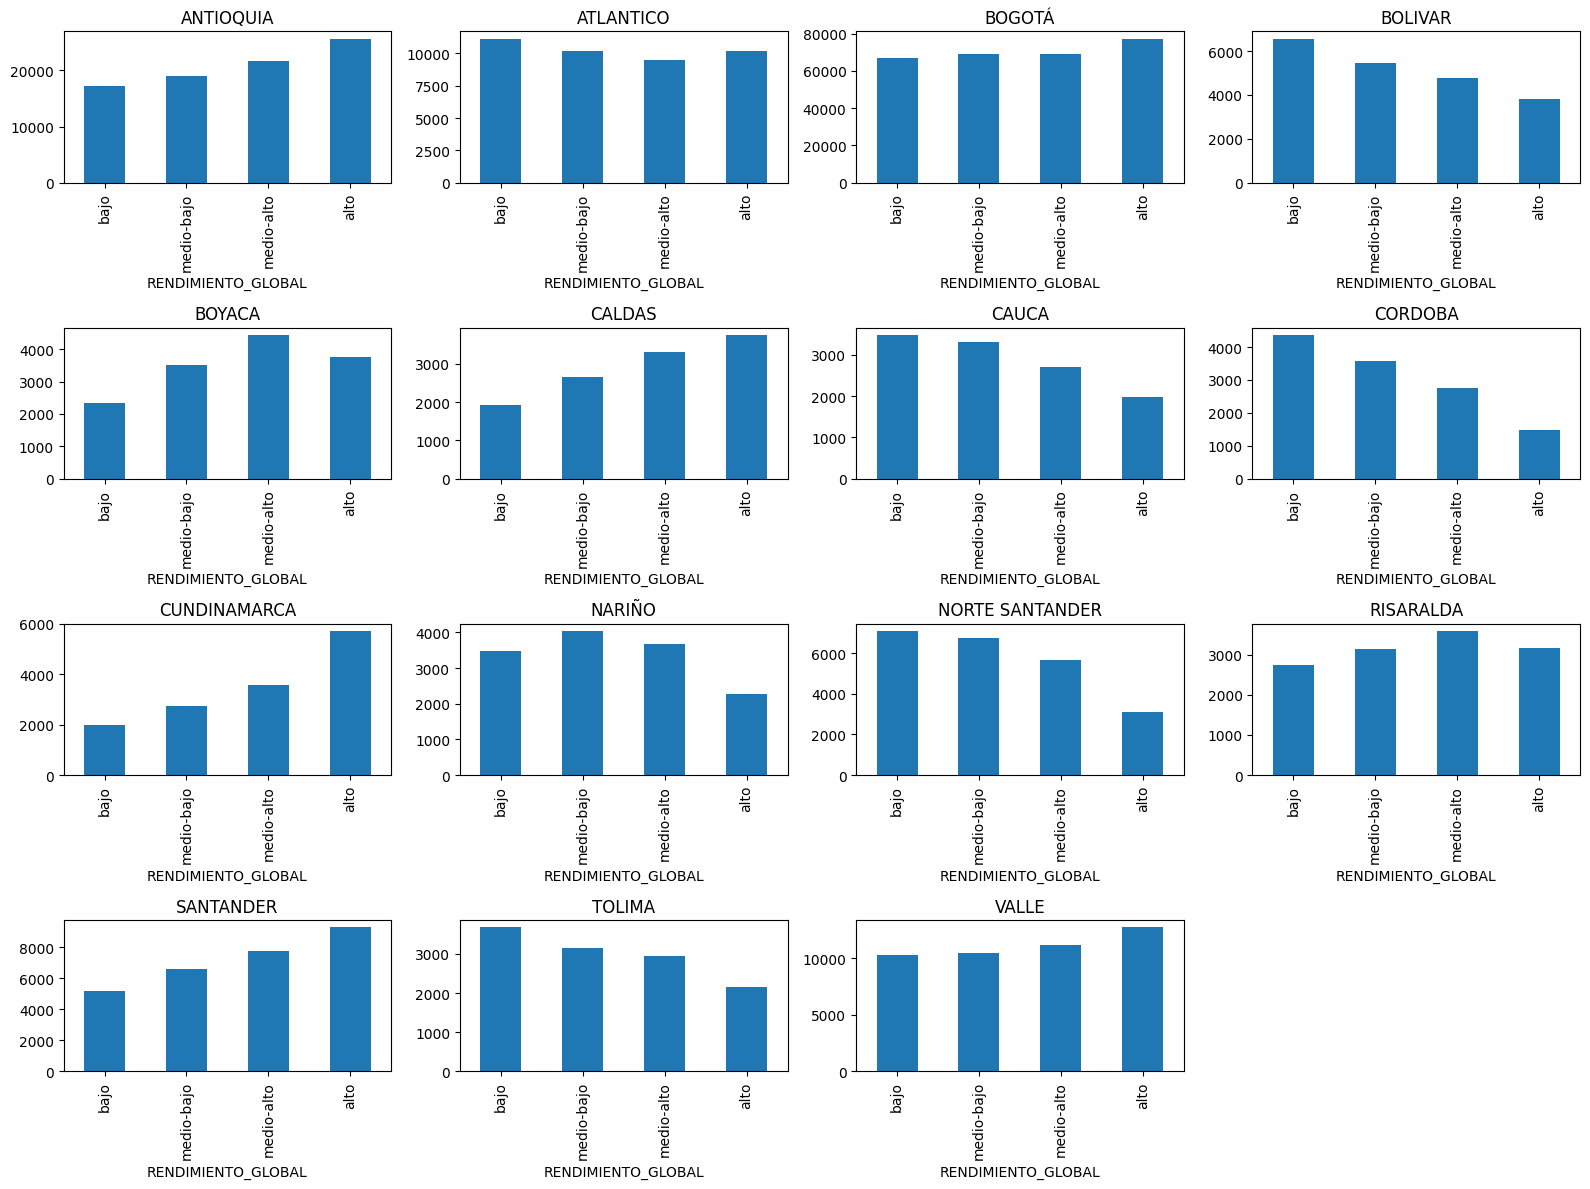

In [25]:
from rlxutils import subplots
import matplotlib.pyplot as plt

c = sorted(z.ESTU_PRGM_DEPARTAMENTO.value_counts().iloc[0:15].index)
for ax,ci in subplots(c, n_cols=4, usizex=4):
    zc = z[z.ESTU_PRGM_DEPARTAMENTO==ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)

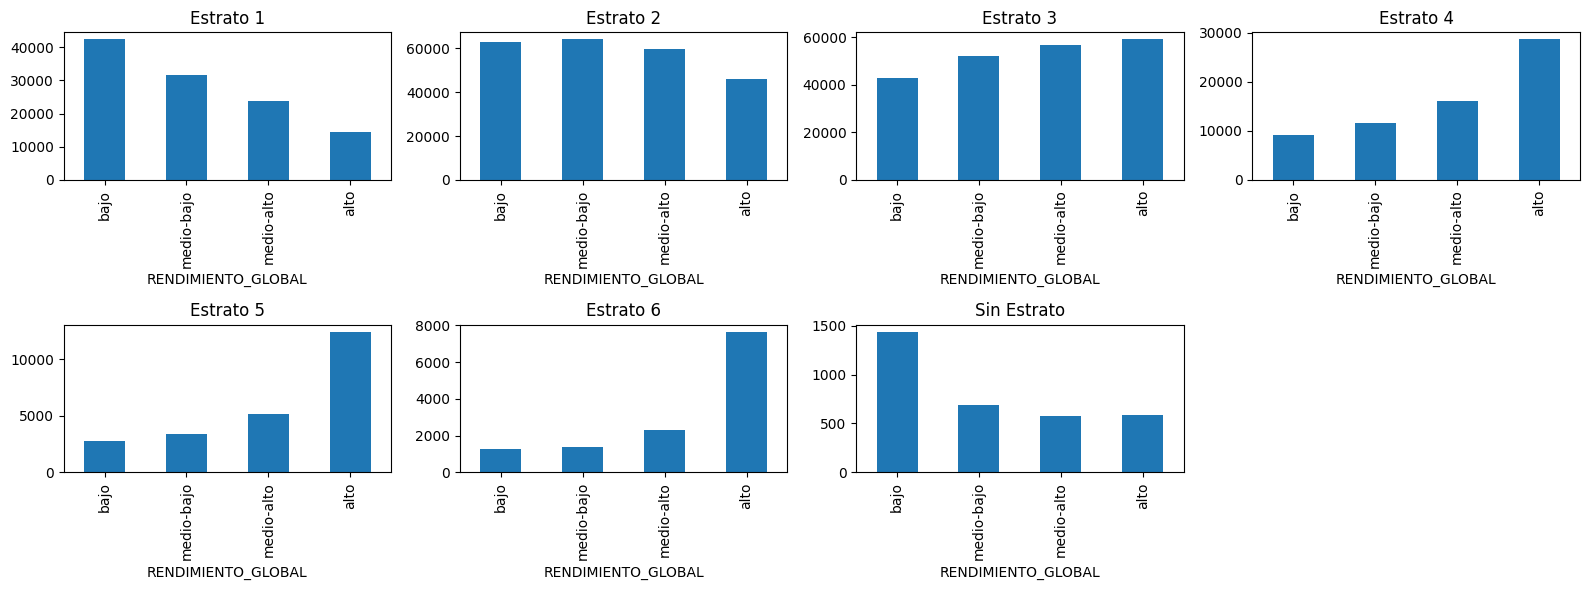

In [26]:
c = sorted(z.FAMI_ESTRATOVIVIENDA.value_counts().index)
for ax,ci in subplots(c, n_cols=4, usizex=4):
    zc = z[z.FAMI_ESTRATOVIVIENDA==ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)


**Limpieza básica**

- Teniendo en cuenta que tenemos un total de 692 000 elementos de datos, tenemos relativamente pocos valores perdidos en cada columna.

In [27]:
sum(z.ESTU_PRGM_DEPARTAMENTO.isna()), sum(z.FAMI_ESTRATOVIVIENDA.isna())

(0, 32137)

- Sustituiremos los valores `nan` por un símbolo preestablecido para marcarlos.

In [28]:
z.FAMI_ESTRATOVIVIENDA.values[z.FAMI_ESTRATOVIVIENDA.isna()] = 'Sin Estrato'

sum(z.ESTU_PRGM_DEPARTAMENTO.isna()), sum(z.FAMI_ESTRATOVIVIENDA.isna())

(0, 0)

- Limpiar `ESTU_PRGM_DEPARTAMENTO`

- Se mapeará `ESTU_PRGM_DEPARTAMENTO` a valores más cortos con el fin de optmizar la visibilidad y visibilidad de los valores.

In [29]:
cmap = {
  "BOGOTÁ": "BOG",
  "ANTIOQUIA": "ANT",
  "VALLE": "VAL",
  "ATLANTICO": "ATL",
  "SANTANDER": "SAN",
  "NORTE SANTANDER": "NSA",
  "BOLIVAR": "BOL",
  "BOYACA": "BOY",
  "CUNDINAMARCA": "CUN",
  "NARIÑO": "NAR",
  "RISARALDA": "RIS",
  "CORDOBA": "COR",
  "TOLIMA": "TOL",
  "CALDAS": "CAL",
  "CAUCA": "CAU",
  "HUILA": "HUI",
  "MAGDALENA": "MAG",
  "SUCRE": "SUC",
  "CESAR": "CES",
  "QUINDIO": "QUI",
  "META": "MET",
  "LA GUAJIRA": "GUA",
  "CHOCO": "CHO",
  "CAQUETA": "CAQ",
  "CASANARE": "CAS",
  "PUTUMAYO": "PUT",
  "ARAUCA": "ARA",
  "AMAZONAS": "AMA",
  "GUAVIARE": "GUV",
  "VAUPES": "VAU",
  "SAN ANDRES": "SAD",
 }

z.ESTU_PRGM_DEPARTAMENTO = np.r_[[cmap[i] for i in z.ESTU_PRGM_DEPARTAMENTO]]
z.ESTU_PRGM_DEPARTAMENTO.value_counts()

,count
ESTU_PRGM_DEPARTAMENTO,
BOG,282159
ANT,83607
VAL,44588
ATL,41020
SAN,28828
NSA,22588
BOL,20629
BOY,14048
CUN,14018


In [30]:
cmap = {
  "Estrato 2": 2,
  "Estrato 3": 3,
  "Estrato 1": 1,
  "Estrato 4": 4,
  "Estrato 5": 5,
  "Estrato 6": 6,
  "Sin Estrato": -1,
}

z.FAMI_ESTRATOVIVIENDA = np.r_[[cmap[i] for i in z.FAMI_ESTRATOVIVIENDA]]
z.FAMI_ESTRATOVIVIENDA.value_counts()

,count
FAMI_ESTRATOVIVIENDA,
2,232671
3,210685
1,111991
4,65514
-1,35426
5,23608
6,12605


first we create the onehot mapping
- Primero, se crea la **onehot mapping**

In [31]:
x = z.ESTU_PRGM_DEPARTAMENTO.values
ESTU_PRGM_DEPARTAMENTO_vals = sorted(np.unique(x))
ESTU_PRGM_DEPARTAMENTO_onehot_vals = {val: np.eye(len(ESTU_PRGM_DEPARTAMENTO_vals))[i] for i,val in enumerate(ESTU_PRGM_DEPARTAMENTO_vals)}
ESTU_PRGM_DEPARTAMENTO_onehot_vals

{'AMA': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'ANT': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'ARA': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'ATL': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'BOG': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'BOL': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'BOY': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

In [32]:
ESTU_PRGM_DEPARTAMENTO_onehot_enc = np.r_[[ESTU_PRGM_DEPARTAMENTO_onehot_vals[i] for i in z.ESTU_PRGM_DEPARTAMENTO]]
ESTU_PRGM_DEPARTAMENTO_onehot_enc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [33]:
ESTU_PRGM_DEPARTAMENTO_df = pd.DataFrame(ESTU_PRGM_DEPARTAMENTO_onehot_enc, columns=[f"ESTU_PRGM_DEPARTAMENTO__{v}" for v in ESTU_PRGM_DEPARTAMENTO_onehot_vals])
ESTU_PRGM_DEPARTAMENTO_df

,ESTU_PRGM_DEPARTAMENTO__AMA,ESTU_PRGM_DEPARTAMENTO__ANT,ESTU_PRGM_DEPARTAMENTO__ARA,ESTU_PRGM_DEPARTAMENTO__ATL,ESTU_PRGM_DEPARTAMENTO__BOG,ESTU_PRGM_DEPARTAMENTO__BOL,ESTU_PRGM_DEPARTAMENTO__BOY,ESTU_PRGM_DEPARTAMENTO__CAL,ESTU_PRGM_DEPARTAMENTO__CAQ,ESTU_PRGM_DEPARTAMENTO__CAS,...,ESTU_PRGM_DEPARTAMENTO__NSA,ESTU_PRGM_DEPARTAMENTO__PUT,ESTU_PRGM_DEPARTAMENTO__QUI,ESTU_PRGM_DEPARTAMENTO__RIS,ESTU_PRGM_DEPARTAMENTO__SAD,ESTU_PRGM_DEPARTAMENTO__SAN,ESTU_PRGM_DEPARTAMENTO__SUC,ESTU_PRGM_DEPARTAMENTO__TOL,ESTU_PRGM_DEPARTAMENTO__VAL,ESTU_PRGM_DEPARTAMENTO__VAU
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
692496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
692497,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
692498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


- Reunimos todo en un único dataframe, eliminando la columna original `ESTU_PRGM_DEPARTAMENTO`.


In [34]:
z = pd.concat([ESTU_PRGM_DEPARTAMENTO_df, z], axis=1).drop('ESTU_PRGM_DEPARTAMENTO', axis=1)
z.shape

(692500, 33)

In [35]:
z.head()

,ESTU_PRGM_DEPARTAMENTO__AMA,ESTU_PRGM_DEPARTAMENTO__ANT,ESTU_PRGM_DEPARTAMENTO__ARA,ESTU_PRGM_DEPARTAMENTO__ATL,ESTU_PRGM_DEPARTAMENTO__BOG,ESTU_PRGM_DEPARTAMENTO__BOL,ESTU_PRGM_DEPARTAMENTO__BOY,ESTU_PRGM_DEPARTAMENTO__CAL,ESTU_PRGM_DEPARTAMENTO__CAQ,ESTU_PRGM_DEPARTAMENTO__CAS,...,ESTU_PRGM_DEPARTAMENTO__QUI,ESTU_PRGM_DEPARTAMENTO__RIS,ESTU_PRGM_DEPARTAMENTO__SAD,ESTU_PRGM_DEPARTAMENTO__SAN,ESTU_PRGM_DEPARTAMENTO__SUC,ESTU_PRGM_DEPARTAMENTO__TOL,ESTU_PRGM_DEPARTAMENTO__VAL,ESTU_PRGM_DEPARTAMENTO__VAU,FAMI_ESTRATOVIVIENDA,RENDIMIENTO_GLOBAL
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,medio-alto
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,bajo
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,bajo
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4,alto
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,medio-bajo


In [36]:
x = z.FAMI_ESTRATOVIVIENDA.values
FAMI_ESTRATOVIVIENDA_vals = sorted(np.unique(x))
FAMI_ESTRATOVIVIENDA_onehot_vals = {val: np.eye(len(FAMI_ESTRATOVIVIENDA_vals))[i] for i,val in enumerate(FAMI_ESTRATOVIVIENDA_vals)}
FAMI_ESTRATOVIVIENDA_onehot_vals

{np.int64(-1): array([1., 0., 0., 0., 0., 0., 0.]),
 np.int64(1): array([0., 1., 0., 0., 0., 0., 0.]),
 np.int64(2): array([0., 0., 1., 0., 0., 0., 0.]),
 np.int64(3): array([0., 0., 0., 1., 0., 0., 0.]),
 np.int64(4): array([0., 0., 0., 0., 1., 0., 0.]),
 np.int64(5): array([0., 0., 0., 0., 0., 1., 0.]),
 np.int64(6): array([0., 0., 0., 0., 0., 0., 1.])}

In [37]:
FAMI_ESTRATOVIVIENDA_onehot_enc = np.r_[[FAMI_ESTRATOVIVIENDA_onehot_vals[i] for i in z.FAMI_ESTRATOVIVIENDA]]
FAMI_ESTRATOVIVIENDA_onehot_enc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [38]:
FAMI_ESTRATOVIVIENDA_df = pd.DataFrame(FAMI_ESTRATOVIVIENDA_onehot_enc, columns=[f"FAMI_ESTRATOVIVIENDA__{v}" for v in FAMI_ESTRATOVIVIENDA_onehot_vals])
FAMI_ESTRATOVIVIENDA_df

,FAMI_ESTRATOVIVIENDA__-1,FAMI_ESTRATOVIVIENDA__1,FAMI_ESTRATOVIVIENDA__2,FAMI_ESTRATOVIVIENDA__3,FAMI_ESTRATOVIVIENDA__4,FAMI_ESTRATOVIVIENDA__5,FAMI_ESTRATOVIVIENDA__6
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
692495,0.0,0.0,1.0,0.0,0.0,0.0,0.0
692496,0.0,0.0,0.0,1.0,0.0,0.0,0.0
692497,0.0,0.0,0.0,1.0,0.0,0.0,0.0
692498,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [39]:
z = pd.concat([FAMI_ESTRATOVIVIENDA_df, z], axis=1).drop('FAMI_ESTRATOVIVIENDA', axis=1)
z.shape

(692500, 39)

In [40]:
z.head()


,FAMI_ESTRATOVIVIENDA__-1,FAMI_ESTRATOVIVIENDA__1,FAMI_ESTRATOVIVIENDA__2,FAMI_ESTRATOVIVIENDA__3,FAMI_ESTRATOVIVIENDA__4,FAMI_ESTRATOVIVIENDA__5,FAMI_ESTRATOVIVIENDA__6,ESTU_PRGM_DEPARTAMENTO__AMA,ESTU_PRGM_DEPARTAMENTO__ANT,ESTU_PRGM_DEPARTAMENTO__ARA,...,ESTU_PRGM_DEPARTAMENTO__PUT,ESTU_PRGM_DEPARTAMENTO__QUI,ESTU_PRGM_DEPARTAMENTO__RIS,ESTU_PRGM_DEPARTAMENTO__SAD,ESTU_PRGM_DEPARTAMENTO__SAN,ESTU_PRGM_DEPARTAMENTO__SUC,ESTU_PRGM_DEPARTAMENTO__TOL,ESTU_PRGM_DEPARTAMENTO__VAL,ESTU_PRGM_DEPARTAMENTO__VAU,RENDIMIENTO_GLOBAL
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medio-alto
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bajo
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bajo
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,alto
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medio-bajo


- Convertir la columna de destino (prediction) en valores discretos

Ahora todo en nuestro conjunto de datos es numérico.

In [41]:
y_col = 'RENDIMIENTO_GLOBAL'

rmap = {'alto': 3, 'bajo':0, 'medio-bajo':1, 'medio-alto':2}
z[y_col] = [rmap[i] for i in z[y_col]]
z.head()

,FAMI_ESTRATOVIVIENDA__-1,FAMI_ESTRATOVIVIENDA__1,FAMI_ESTRATOVIVIENDA__2,FAMI_ESTRATOVIVIENDA__3,FAMI_ESTRATOVIVIENDA__4,FAMI_ESTRATOVIVIENDA__5,FAMI_ESTRATOVIVIENDA__6,ESTU_PRGM_DEPARTAMENTO__AMA,ESTU_PRGM_DEPARTAMENTO__ANT,ESTU_PRGM_DEPARTAMENTO__ARA,...,ESTU_PRGM_DEPARTAMENTO__PUT,ESTU_PRGM_DEPARTAMENTO__QUI,ESTU_PRGM_DEPARTAMENTO__RIS,ESTU_PRGM_DEPARTAMENTO__SAD,ESTU_PRGM_DEPARTAMENTO__SAN,ESTU_PRGM_DEPARTAMENTO__SUC,ESTU_PRGM_DEPARTAMENTO__TOL,ESTU_PRGM_DEPARTAMENTO__VAL,ESTU_PRGM_DEPARTAMENTO__VAU,RENDIMIENTO_GLOBAL
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


- Construir el `X` y `y` para entrenar el modelo

Observar que ordenamos las columnas para asegurarnos de que siempre obtenemos el mismo orden.

In [42]:
z = z[sorted(z.columns)]

X = z[[c for c in z.columns if c!=y_col]].values
y = z[y_col].values
X.shape, y.shape

((692500, 38), (692500,))

- Partir en train y test

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
Xtr, Xts, ytr, yts = train_test_split(X,y, train_size=0.8)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((554000, 38), (138500, 38), (554000,), (138500,))

- Hacer un Clasificador por Arbol de Decisión

In [45]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(Xtr, ytr)

DecisionTreeClassifier(max_depth=3, random_state=42)

- Obtener las predicciones

In [46]:
preds_tr = dt.predict(Xtr)
preds_ts = dt.predict(Xts)

In [47]:
print (preds_tr[:10])
print (preds_ts[:10])

[3 3 1 3 3 1 1 0 3 3]
[3 3 0 3 2 0 1 1 3 0]


- Obtener la precisión y las matrices de confusión

In [48]:
np.mean(preds_tr==ytr), np.mean(preds_ts==yts)

(np.float64(0.32062996389891696), np.float64(0.32258483754512635))

In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
cm_tr = confusion_matrix(ytr, preds_tr)
cm_ts = confusion_matrix(yts, preds_ts)

# normalize by class
cm_tr = cm_tr / cm_tr.sum(axis=1).reshape(-1,1)
cm_ts = cm_ts / cm_ts.sum(axis=1).reshape(-1,1)

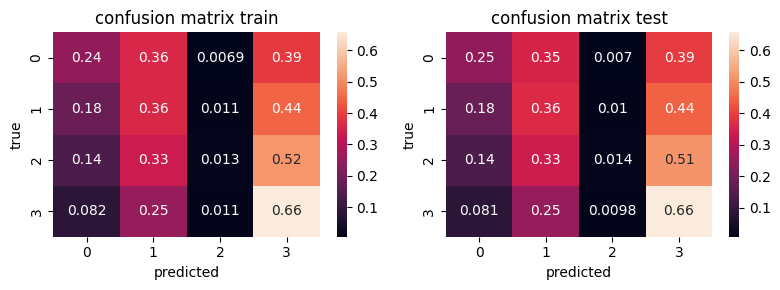

In [51]:
import seaborn as sns
for ax,i in subplots(2, usizex=4):
  if i==0: sns.heatmap(cm_tr, annot=True); plt.title("confusion matrix train")
  if i==1: sns.heatmap(cm_ts, annot=True); plt.title("confusion matrix test")
  plt.ylabel("true")
  plt.xlabel("predicted")

Ahora aplicamos el mismo procedimiento a `test.csv`.

Observar que:
- no hay ninguna columna `RENDIMIENTO_GLOBAL`;

In [52]:
zt = pd.read_csv("test.csv")
zt.head()
zt_ids = zt.ID.values

zt = zt[['ESTU_PRGM_DEPARTAMENTO',	'FAMI_ESTRATOVIVIENDA']]

In [53]:
cmap = {
  "BOGOTÁ": "BOG",
  "ANTIOQUIA": "ANT",
  "VALLE": "VAL",
  "ATLANTICO": "ATL",
  "SANTANDER": "SAN",
  "NORTE SANTANDER": "NSA",
  "BOLIVAR": "BOL",
  "BOYACA": "BOY",
  "CUNDINAMARCA": "CUN",
  "NARIÑO": "NAR",
  "RISARALDA": "RIS",
  "CORDOBA": "COR",
  "TOLIMA": "TOL",
  "CALDAS": "CAL",
  "CAUCA": "CAU",
  "HUILA": "HUI",
  "MAGDALENA": "MAG",
  "SUCRE": "SUC",
  "CESAR": "CES",
  "QUINDIO": "QUI",
  "META": "MET",
  "LA GUAJIRA": "GUA",
  "CHOCO": "CHO",
  "CAQUETA": "CAQ",
  "CASANARE": "CAS",
  "PUTUMAYO": "PUT",
  "ARAUCA": "ARA",
  "AMAZONAS": "AMA",
  "GUAVIARE": "GUV",
  "VAUPES": "VAU",
  "SAN ANDRES": "SAD",
 }

zt.ESTU_PRGM_DEPARTAMENTO = np.r_[[cmap[i] for i in zt.ESTU_PRGM_DEPARTAMENTO]]
zt.ESTU_PRGM_DEPARTAMENTO.value_counts()
cmap = {
  "Estrato 2": 2,
  "Estrato 3": 3,
  "Estrato 1": 1,
  "Estrato 4": 4,
  "Estrato 5": 5,
  "Estrato 6": 6,
  "Sin Estrato": -1,
}

zt.FAMI_ESTRATOVIVIENDA.values[zt.FAMI_ESTRATOVIVIENDA.isna()] = 'Sin Estrato'

zt.FAMI_ESTRATOVIVIENDA = np.r_[[cmap[i] for i in zt.FAMI_ESTRATOVIVIENDA]]
zt.FAMI_ESTRATOVIVIENDA.value_counts()
x = zt.ESTU_PRGM_DEPARTAMENTO.values
ESTU_PRGM_DEPARTAMENTO_vals = sorted(np.unique(x))
ESTU_PRGM_DEPARTAMENTO_onehot_vals = {val: np.eye(len(ESTU_PRGM_DEPARTAMENTO_vals))[i] for i,val in enumerate(ESTU_PRGM_DEPARTAMENTO_vals)}
ESTU_PRGM_DEPARTAMENTO_onehot_vals
ESTU_PRGM_DEPARTAMENTO_onehot_enc = np.r_[[ESTU_PRGM_DEPARTAMENTO_onehot_vals[i] for i in zt.ESTU_PRGM_DEPARTAMENTO]]
ESTU_PRGM_DEPARTAMENTO_onehot_enc
ESTU_PRGM_DEPARTAMENTO_df = pd.DataFrame(ESTU_PRGM_DEPARTAMENTO_onehot_enc, columns=[f"ESTU_PRGM_DEPARTAMENTO__{v}" for v in ESTU_PRGM_DEPARTAMENTO_onehot_vals])
ESTU_PRGM_DEPARTAMENTO_df
zt = pd.concat([ESTU_PRGM_DEPARTAMENTO_df, zt], axis=1).drop('ESTU_PRGM_DEPARTAMENTO', axis=1)
zt.shape
x = zt.FAMI_ESTRATOVIVIENDA.values
FAMI_ESTRATOVIVIENDA_vals = sorted(np.unique(x))
FAMI_ESTRATOVIVIENDA_onehot_vals = {val: np.eye(len(FAMI_ESTRATOVIVIENDA_vals))[i] for i,val in enumerate(FAMI_ESTRATOVIVIENDA_vals)}
FAMI_ESTRATOVIVIENDA_onehot_vals
FAMI_ESTRATOVIVIENDA_onehot_enc = np.r_[[FAMI_ESTRATOVIVIENDA_onehot_vals[i] for i in zt.FAMI_ESTRATOVIVIENDA]]
FAMI_ESTRATOVIVIENDA_onehot_enc
FAMI_ESTRATOVIVIENDA_df = pd.DataFrame(FAMI_ESTRATOVIVIENDA_onehot_enc, columns=[f"FAMI_ESTRATOVIVIENDA__{v}" for v in FAMI_ESTRATOVIVIENDA_onehot_vals])
FAMI_ESTRATOVIVIENDA_df
zt = pd.concat([FAMI_ESTRATOVIVIENDA_df, zt], axis=1).drop('FAMI_ESTRATOVIVIENDA', axis=1)
zt.shape


(296786, 38)

- Crear el areglo `X` y predecir

In [54]:
X_test_data = zt[sorted(zt.columns)].values
X_test_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
preds_test_data = dt.predict(X_test_data)

In [56]:
# Hacer el mapeo inverso
rmapi = {v:k for k,v in rmap.items()}
text_preds_test_data = [rmapi[i] for i in preds_test_data]


In [57]:
# Crear el dataframe con los datos de respuesta, más adelante se transformará a un JSON para retornar por medio de una API

submission = pd.DataFrame([zt_ids, text_preds_test_data], index=['ID', 'RENDIMIENTO_GLOBAL']).T
submission

,ID,RENDIMIENTO_GLOBAL
0,550236,alto
1,98545,medio-bajo
2,499179,alto
3,782980,bajo
4,785185,medio-bajo
...,...,...
296781,496981,bajo
296782,209415,alto
296783,239074,alto
296784,963852,alto
